In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import inspect
from datetime import datetime
import logging
import sys
import pandas as pd

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('Experiment')

In [3]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')

In [4]:
path = os.path.join(DIR_PATH, "duration", 'merged_df.csv')
df =pd.read_csv(path)
df

,Unnamed: 0,Learning Problem,Model,Dataset,Duration,UseGPU
0,4,ChoiceModel,AllPositive,Expedia 10 Objects,2756,False
1,6,ChoiceModel,FATE-Linear,Expedia 10 Objects,133761,True
2,63,ChoiceModel,FATE-Net,Expedia 10 Objects,23002,True
3,53,ChoiceModel,FETA-Linear,Expedia 10 Objects,115694,True
4,23,ChoiceModel,FETA-Net,Expedia 10 Objects,17380,True
...,...,...,...,...,...,...
403,100,Ranker,FETA-Net,Tag Genome Similar Movie,111192,True
404,22,Ranker,ListNet,Tag Genome Similar Movie,36954,True
405,12,Ranker,Random,Tag Genome Similar Movie,6624,False
406,78,Ranker,RankNet,Tag Genome Similar Movie,64570,True


In [8]:
cols = ["All", "Duration"]
x = (df["Duration"].sum()/(60*60)).round(2)
l = len(df["Duration"])
x*(0.3)/(l)

11.691176470588236

In [12]:
d = df[df['Model'].str.contains("FATE-Net")]["Duration"]
x = d.sum()/(60*60)
l = len(d)
x*(0.3)/(l)

20.73089375

In [13]:
d = df[df['Model'].str.contains("FATE-Net")]["Duration"]
x = d.sum()/(60*60)
l = len(d)
x*(0.3)/(l)

20.73089375

In [8]:
def get_data(jobs, data, learning_problem):
    functions = learning_functions_dict[learning_problem]
    learning_model = learners_map[learning_problem]
    models_dict = dict(zip(functions, learning_models_dict[learning_problem]))
    for job in jobs:
        job = dict(job)
        ext = ''#'_'+get_hash_string(logger=logger, job=job)
        job['learner'] = job['learner']
        if "letor" in job['dataset'] or "exp" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'], learning_problem)
        elif "sushi" in job['dataset']:
            job['dataset'] = job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['dataset'] =  get_dataset_name(job['dataset'].title())
        del job['dataset_params']
        del job['learner_params']
        file = os.path.join(DIR_PATH, 'logs', '{}.log'.format(job['hash_value']))
        #print(job['hash_value'])
        if os.path.exists(file):
            f = open(file, 'r')
            string = f.readlines()
            dates = []
            for i, s in enumerate(string):
                if 'SetupLogger' in s:
                    if i!=0:
                        k = i-1
                        while True:
                            try:
                                d = datetime.strptime(string[k][0:19], "%Y-%m-%d %H:%M:%S")
                                dates.append(d)
                                break
                            except:
                                k-=1
                    s = s[0:19].replace('\n', '')
                    dates.append(datetime.strptime(s, "%Y-%m-%d %H:%M:%S"))
            #print(string[-1][0:19])
            dates.append(datetime.strptime(string[-1][0:19], "%Y-%m-%d %H:%M:%S"))
            #print(dates, len(dates))
            duration = 0
            for start,end in zip(dates[0::2], dates[1::2]):
                #print((end-start), start, end)
                duration += (end-start).seconds
        if duration ==0:
            duration = get_duration_seconds(job['duration'])
        job['duration'] = duration
        job['learner'] = models_dict.get(job['learner'], job['learner'])
        del job['hash_value']
        ##print(job)
        l = [learners_map[learning_problem]] + list(job.values())
        data.append(l)
        #print('*************************************************************************')
    return data

In [9]:
def get_df(learning_problem):
    select_st = "SELECT learner, learner_params, dataset, dataset_params, hash_value, duration, is_gpu from {}.avail_jobs where fold_id=0"
    if learning_problem == CHOICE_FUNCTION:
        select_cmd = select_st.format(learning_problem+'s')
    else:
        select_cmd = select_st.format(learning_problem)

        #config_file_path = 
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=learning_problem)
    self.init_connection()
    self.cursor_db.execute(select_cmd)
    logs_dir = os.path.join(DIR_PATH, 'logs')
    jobs = self.cursor_db.fetchall()
    self.close_connection()

    data = []
    data = get_data(jobs, data, learning_problem)
    if learning_problem == DISCRETE_CHOICE:
        self.init_connection()
        select_st = select_st.format('pymc3_' + DISCRETE_CHOICE)
        self.cursor_db.execute(select_st)
        jobs = self.cursor_db.fetchall()

        data = get_data(jobs, data, learning_problem)
        self.close_connection()
    columns = ['Learning Problem', 'Model' ,'Dataset', 'Duration', 'UseGPU']
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by=['Dataset', 'Learning Problem', 'Model'], inplace=True)
    return df
dfs = []
for learning_problem in [CHOICE_FUNCTION, DISCRETE_CHOICE, OBJECT_RANKING]:
    
    df = get_df(learning_problem)
    for dataset, dgroup in df.groupby(['Dataset']):
        duration = dgroup[dgroup['Model'].isin(['FETA-Net'])]['Duration'].mean()
        df.loc[(df['Model']=='FETA-Net') & (df['Dataset']==dataset)]['Duration'] = duration
    df = df.drop_duplicates()
    dfs.append(df)

INFO:DBConnector:Config {  "dbname": "clusterdb",  "user": "cluster",  "password": "qW34!XFRzR",  "host": "csr-clusterdb.cs.upb.de",  "port": 5432}
INFO:DBConnector:Connection Successful


NameError: name 'learning_functions_dict' is not defined

In [20]:
merged_df = pd.concat(dfs)
merged_df.to_csv(os.path.join(DIR_PATH, 'merged_df.csv'))

In [29]:
(merged_df['Duration'].mean()/(60*60)).round(2)

38.97

In [27]:
(merged_df[merged_df.UseGPU]['Duration'].sum()/(60*60)).round(2)

10097.35

In [28]:
(merged_df[~merged_df.UseGPU]['Duration'].sum()/(60*60)).round(2)

5802.65

In [ ]:
files = os.path.join(os.getcwd(), "logs", "*.log")
files = glob.glob(files)
for file in files:
    with open(file) as f:
        file_ =  f.read()
        if 'fatelinear_ranker' in file_ and "hypervolume" in file_:
            print("true", file)
            file_

In [ ]:
'Fate, medoid of 0.4505: [234, 0.08858513268691572, 1013, 146, 0.4607117081739425]'
'Feta, medoid of 0.4186:  [0.09984350703883657, 43, 103, 0.30440122790492]'
'FEta hypervolume 0.4199: [0.03642928475940855, 1024, 68, 0.01]'
'Fate hypervolue 0.4485: [126, 0.1, 32, 150, 0.01]'

In [3]:
import logging
rootLogger = logging.getLogger('')
rootLogger.setLevel(logging.INFO)
logFormatter = logging.Formatter("%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logFormatter)
rootLogger.addHandler(consoleHandler)

In [4]:
from csrank import ExpediaDiscreteChoiceDatasetReader
import numpy as np
dr = ExpediaDiscreteChoiceDatasetReader(n_objects=10, fold_id=4,random_state= np.random.RandomState(seed=42 + 4))
_,_,x,y = dr.get_single_train_test_split()

Using TensorFlow backend.
I1101 15:59:54.481148 139940215146304 dataset_reader.py:34] Learning Problem: discrete_choice
I1101 16:00:00.654258 139940215146304 expedia_dataset_reader.py:29] Done loading the dataset
I1101 16:00:01.718835 139940215146304 expedia_dataset_reader.py:119] Sampled instances 1460 from objects 10
I1101 16:00:02.204896 139940215146304 expedia_dataset_reader.py:119] Sampled instances 1542 from objects 11
I1101 16:00:02.661779 139940215146304 expedia_dataset_reader.py:119] Sampled instances 1480 from objects 12
I1101 16:00:03.193498 139940215146304 expedia_dataset_reader.py:119] Sampled instances 1467 from objects 13
I1101 16:00:03.577910 139940215146304 expedia_dataset_reader.py:119] Sampled instances 1395 from objects 14
I1101 16:00:04.044952 139940215146304 expedia_dataset_reader.py:119] Sampled instances 1417 from objects 15
I1101 16:00:04.462865 139940215146304 expedia_dataset_reader.py:119] Sampled instances 1396 from objects 16
I1101 16:00:04.890295 139940215

In [77]:
from itertools import product
diffs = []
X = np.arange(5, 40, 1)
Y = np.arange(0, 1.0, 0.0001)
probs = np.array(list(product(X, Y)))
print(probs.shape)
for k, acc in probs:
    n = (acc*k-1)/(k-1)
    diff = (1-acc)/(k-1)
    diffs.append(diff)
diffs = np.array(diffs)
diffs

(35000, 2)


array([0.2125    , 0.212475  , 0.21245   , ..., 0.01974474, 0.01974211,
       0.01973947])

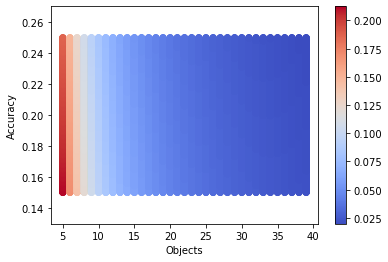

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
%matplotlib inline
X, Y = probs[:, 0], probs[:, 1]
cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots()
sc = plt.scatter(X, Y, c=diffs, cmap=cmap, label='matches')
plt.xlabel('Objects')
plt.ylabel('Accuracy')

fig.colorbar(sc)
fig_param = {'facecolor': 'w', 'edgecolor': 'w', 'transparent': False, 'dpi': 800, 'format': 'png',
             'bbox_inches': 'tight', 'pad_inches': 0.05}
plt.show()

In [80]:
X = np.arange(5, 40, 1)
Y = np.arange(0, 0.3, 0.001)
k=2
for no in X:
    diffs = []
    for acc in Y:
        diff = (k*(1-acc))/(no-k)
        diffs.append(diff)
    diffs = np.array(diffs)
    means[no] = (np.min(diffs), np.mean(diffs), np.max(diffs))
means

{5: (0.4673333333333334, 0.567, 0.6666666666666666),
 6: (0.35050000000000003, 0.42525, 0.5),
 7: (0.28040000000000004, 0.3402, 0.4),
 8: (0.2336666666666667, 0.2835, 0.3333333333333333),
 9: (0.20028571428571432, 0.24300000000000002, 0.2857142857142857),
 10: (0.17525000000000002, 0.212625, 0.25),
 11: (0.1557777777777778, 0.189, 0.2222222222222222),
 12: (0.14020000000000002, 0.1701, 0.2),
 13: (0.12745454545454546, 0.15463636363636363, 0.18181818181818182),
 14: (0.11683333333333334, 0.14175, 0.16666666666666666),
 15: (0.10784615384615386, 0.13084615384615386, 0.15384615384615385),
 16: (0.10014285714285716, 0.12150000000000001, 0.14285714285714285),
 17: (0.09346666666666667, 0.11339999999999999, 0.13333333333333333),
 18: (0.08762500000000001, 0.1063125, 0.125),
 19: (0.08247058823529413, 0.10005882352941176, 0.11764705882352941),
 20: (0.0778888888888889, 0.0945, 0.1111111111111111),
 21: (0.07378947368421053, 0.08952631578947369, 0.10526315789473684),
 22: (0.07010000000000001,

In [81]:
ranges = {}
X = np.arange(5, 50, 1)
Y = np.arange(0, 1, 0.001)
for k in np.arange(1, 6):
    means = {}
    for no in X:
        diffs = []
        for acc in Y:
            diff = (k*(1-acc))/(no-k)
            diffs.append(diff)
        diffs = np.array(diffs)
        means[no] = (np.min(diffs), np.mean(diffs), np.max(diffs))
    tmin = 0
    tmean = 0
    tmax = 0
    n = 0
    for key, v in x.items():
        if key>=10:
            m1, m2, m3 = means[key]
            tmin+=m1*v.shape[0]
            tmean+=m2*v.shape[0]
            tmax+=m3*v.shape[0]
            n+=v.shape[0]
    ranges[k] = (tmin/n, tmean/n , tmax/n)
ranges

{1: (4.362474273791786e-05, 0.021834183740327872, 0.04362474273791783),
 2: (9.213000271327263e-05, 0.0461110663579929, 0.09213000271327254),
 3: (0.00014665019238223697, 0.07339842128730956, 0.1466501923822369),
 4: (0.00020881413629729998, 0.10451147521679856, 0.20881413629729975),
 5: (0.00028111295863213534, 0.14069703579538356, 0.28111295863213503)}

In [79]:
ranges

{1: (4.362474273791786e-05, 0.021834183740327872, 0.04362474273791783),
 2: (9.213000271327263e-05, 0.0461110663579929, 0.09213000271327254),
 3: (0.00014665019238223697, 0.07339842128730956, 0.1466501923822369),
 4: (0.00020881413629729998, 0.10451147521679856, 0.20881413629729975),
 5: (0.00028111295863213534, 0.14069703579538356, 0.28111295863213503)}

In [ ]:
0.04342767295082038, 0.04631957038302037 ,0.04921146781522036